# Experimento de classificação

Nos experimentos a seguir lidaremos com um problema de classificação "binário", envolvendo apenas $\omega_1$ e $\omega_2$.

Serão utilizados os classificadores:

* Máxima Verossimilhança - ML: $(\mathbf{x} , \omega_j)  \Leftrightarrow \underset{\omega_j \in \Omega}{\arg \max} \ p(\mathbf{x}|\omega_j)$

* Mínima Distância Euclidiana - MDE: $(\mathbf{x} , \omega_j)  \Leftrightarrow \underset{\omega_j \in \Omega}{\arg \min} \ { \| \mathbf{x} - \mathbf{\mu}_i \|}$

* K-Vizinhos Mais Próximos - KNN: $(\mathbf{x} , \omega_j)  \Leftrightarrow \underset{\omega_j \in \Omega}{\arg \min} \  \{m_j \rho_{kj}(\mathbf{x})\} $

Os dados de "treinamento" ($\mathcal{D}$) e "classificação" ($\mathcal{I}$) são obtidos via simulação -- disponibilizados em "saidaSim_D.txt" e "saidaSim_I.txt", respectivamente.

A avaliação será realizada com base no percentual de concordância entre o rótulo dos dados de $\mathcal{I}$ e a classe estimada por cada um dos métodos.

## Importação das bibliotecas

In [2]:
import numpy as np                      #Função para operação matricial e etc.

import matplotlib.pyplot as plt         #Função para geração de gráficos
from matplotlib import cm               #Acesso à paletas de cores pré-definidas
import matplotlib.gridspec as gridspec  #Útil para oragnizar as figuras em subgráficos

import csv                              #Necessário na função implementada para leitura de dados

#Permite o uso do LaTeX nos gráficos a serem gerados
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Definição das funções utilizadas

In [3]:
#Função para ler os arquivos de dados no formato estabelecido--------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x


#Função para cálculo da verossimilhança da observação----------------------------
def multivariate_gaussian(x, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    fator = 1 / np.sqrt((2*np.pi)**n * Sigma_det)
    expo =  ( ((x-mu).T).dot( Sigma_inv ) ).dot(x-mu)
    return np.exp(-0.5*expo) / fator


#Cálculo de uma unidade de hiper-volume------------------------------------------
def unit_space_volume(n):
    if n%2 == 0:
        return (np.pi ** (n//2))/np.math.factorial(n/2)
    else:
        return (2**n) * (np.pi ** ((n-1)/2)) * np.math.factorial(((n-1)/2)) * np.math.factorial(n)

    
#Cálculo da probabilidade estimada pelo método KNN--------------------------------  
def prob_knn(x,k,dataSet,V0):
    m = np.shape(dataSet)[0]
    n = np.shape(dataSet)[1]
    
    dist = np.zeros(m)
    for i in range(0,m):
        v = (dataSet[i,:] - x)
        dist[i] = np.sqrt( v.dot(v.T) )
        
    dist.sort() #coloca em ordem decrescente...

    Vk = V0 * (dist[k-1] ** n)
    
    return k/(m * Vk)


#Cálculo da distância euclidiana entre os vetores A e B---------------------------
def euclid_dist(A, B):
    d =  (A - B)
    return np.linalg.norm(d)

## Leitura dos conjuntos de dados $\mathcal{D}$ e $\mathcal{I}$
* Os conjuntos $\mathcal{D}$ e $\mathcal{I}$ foram gerados por um procedimento anterior!

In [5]:
pathD = 'saidaSim_D.txt' #Devem estar no mesmo diretório deste "Jupyter-Notebook"
pathI = 'saidaSim_I.txt'

yD,xD = read_class_data(pathD)
yI,xI = read_class_data(pathI)

## Definição de variáveis e itens de referência

In [6]:
#Posições onde ocorre exemplos das classes 1 e 2
cla1 = np.where(yD == 1)[0]
cla2 = np.where(yD == 2)[0]

#Vetor que conterá as predições
predML = np.copy(yI)
predMDE = np.copy(yI)
predKNN = np.copy(yI)

m = yI.shape[0] #Quantidade de itens a serem classificados

## Estimação/definição de parâmetros exigidos pelos métodos ML, MDE,e KNN 

In [8]:
#ML----------------
dim = xD.shape[1]
mu1 = np.zeros(dim); mu2 = np.zeros(dim)
for i in range(0,dim):
    mu1[i] = np.mean( xD[cla1,i] )
    mu2[i] = np.mean( xD[cla2,i] )
    
sigma1 = np.cov( (xD[cla1,:]).T ) #transposição '.T' para compatibilizar
sigma2 = np.cov( (xD[cla2,:]).T )

#MDE não possui parâmetros :)

#KNN---------------
k = 5 
V0 = unit_space_volume(dim)

## O processo de classificação...

In [12]:
for i in range(0,m):
    
    padrao = xI[i,:] #Padrão a ser classificado

    #Classificação ML
    if ( multivariate_gaussian(padrao, mu1, sigma1) >= multivariate_gaussian(padrao, mu2, sigma2) ):
        predML[i] = 1
    else: predML[i] = 2

    #Classificação MDE
    if euclid_dist(padrao, mu1) <= euclid_dist(padrao, mu2):
        predMDE[i] = 1
    else:
        predMDE[i] = 2

    #Classificação KNN
    if prob_knn(padrao,k,xD[cla1,:],V0) >= prob_knn(padrao,k,xD[cla2,:],V0):
        predKNN[i] = 1
    else:
        predKNN[i] = 2

In [16]:
np.count_nonzero( predML == yI )/m

0.818

## Verificação da acurácia de cada um dos métodos

In [17]:
#Cálculo do número de acertos (igualdade é True --> 1) 
acertoML  = np.count_nonzero( yI == predML ) / m
acertoMDE = np.count_nonzero( yI == predMDE ) / m
acertoKNN = np.count_nonzero( yI == predKNN ) / m

print("Acertos ML: %f \nAcertos MDE: %f \nAcertos KNN: %f"%(acertoML,acertoMDE,acertoKNN))

Acertos ML: 0.818000 
Acertos MDE: 0.939000 
Acertos KNN: 0.899000


## Adicional - apenas para visulaizar as regiões de decisão e a noção de acerto/erro
É importante observar algumas características no código abaixo:
* São definidas variáveis para armazenar a classificação sobre padrões no espaço de atributos $\mathbb{R}^2$
* Selecionamos este espaço em função da possiblidade de visualizar os resultados


In [18]:
#Número de itens/atributo
N = 200 

#Definição espaço de atributos -- intervalo de valores em cada eixo (xmin~xmax) X (ymin ~ymax)
xmin = np.min( np.array( [ np.min(xD[:,0]) , np.min(xI[:,0]) ] ) )
xmax = np.max( np.array( [ np.max(xD[:,0]) , np.max(xI[:,0]) ] ) )
ymin = np.min( np.array( [ np.min(xD[:,1]) , np.min(xI[:,1]) ] ) )
ymax = np.max( np.array( [ np.max(xD[:,1]) , np.max(xI[:,1]) ] ) )

#Definição de uma matriz para cada método, que deve armazenar o rótulo em cada posição do espaço de atributos
claML = np.ndarray( (N,N) )
claMDE = np.ndarray( (N,N) )
claKNN = np.ndarray( (N,N) )

#Útil o experimento e para os gráficos a seguir
X1 = np.linspace(xmin, xmax, N)
X2 = np.linspace(ymin, ymax, N)

for i in range(0,N):
    for j in range(0,N):

        padrao = [X1[i],X2[j]]

        #Classificação ML
        if ( multivariate_gaussian(padrao, mu1, sigma1) >= multivariate_gaussian(padrao, mu2, sigma2) ):
            claML[i,j] = 1
        else: claML[i,j] = 2

        #Classificação MDE
        if euclid_dist(padrao, mu1) <= euclid_dist(padrao, mu2):
            claMDE[i,j] = 1
        else:
            claMDE[i,j] = 2

        #Classificação KNN
        if prob_knn(padrao,k,xD[cla1,:],V0) >= prob_knn(padrao,k,xD[cla2,:],V0):
            claKNN[i,j] = 1
        else:
            claKNN[i,j] = 2

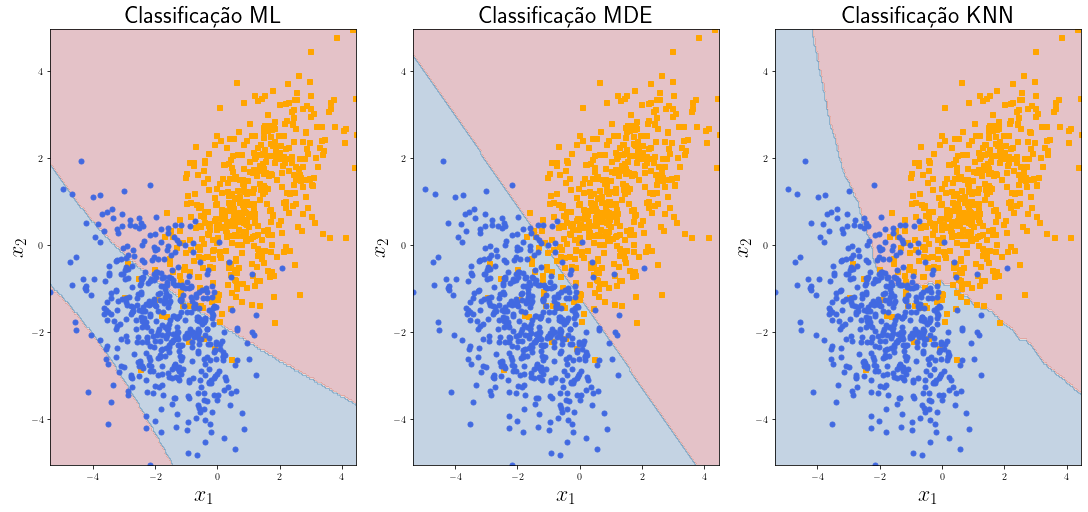

In [19]:
FS = (15,7) #Tamanho da figura a ser gerada

fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)


# Subplot 1 ------------------------
ax1 = fig.add_subplot(spec[0, 0])
#ax1.contourf(LSX1, LSX2, claML, cmap=cm.RdBu,alpha=0.25)
ax1.contourf(X1, X2, claML, cmap=cm.RdBu,alpha=0.25)
ax1.plot(xI[ np.where(yI == 1) ,0], xI[np.where(yI == 1) ,1], 's', color='orange', markersize=5)
ax1.plot(xI[ np.where(yI == 2) ,0], xI[np.where(yI == 2) ,1], 'o', color='royalblue', markersize=5)
ax1.set_xlabel('$x_1$', fontsize=22)
ax1.set_ylabel('$x_2$', fontsize=22)
ax1.set_title('Classificação ML', fontsize=24)
ax1.set_xlim( xmin,xmax )
ax1.set_ylim( ymin,ymax )



# Subplot 2 ------------------------
ax1 = fig.add_subplot(spec[0, 1])
#ax1.contourf(LSX1, LSX2, claMDE, cmap=cm.RdBu,alpha=0.25)
ax1.contourf(X1, X2, claMDE, cmap=cm.RdBu,alpha=0.25)
ax1.plot(xI[ np.where(yI == 1) ,0], xI[np.where(yI == 1) ,1], 's', color='orange', markersize=5)
ax1.plot(xI[ np.where(yI == 2) ,0], xI[np.where(yI == 2) ,1], 'o', color='royalblue', markersize=5)
ax1.set_xlabel('$x_1$', fontsize=22)
ax1.set_ylabel('$x_2$', fontsize=22)
ax1.set_title('Classificação MDE', fontsize=24)
ax1.set_xlim( xmin,xmax )
ax1.set_ylim( ymin,ymax )



# Subplot 3 ------------------------
ax1 = fig.add_subplot(spec[0, 2])
#ax1.contourf(LSX1, LSX2, claKNN, cmap=cm.RdBu,alpha=0.25)
ax1.contourf(X1, X2, claKNN, cmap=cm.RdBu,alpha=0.25)
ax1.plot(xI[ np.where(yI == 1) ,0], xI[np.where(yI == 1) ,1], 's', color='orange', markersize=5)
ax1.plot(xI[ np.where(yI == 2) ,0], xI[np.where(yI == 2) ,1], 'o', color='royalblue', markersize=5)
ax1.set_xlabel('$x_1$', fontsize=22)
ax1.set_ylabel('$x_2$', fontsize=22)
ax1.set_title('Classificação KNN', fontsize=24)
ax1.set_xlim( xmin,xmax )
ax1.set_ylim( ymin,ymax )

plt.show() #Apenas para mostrar os gráficos gerados... (talvez nao necessário no Jupyter!)